d:\Handwritten_Digit_Recogniser\dig_rec_env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


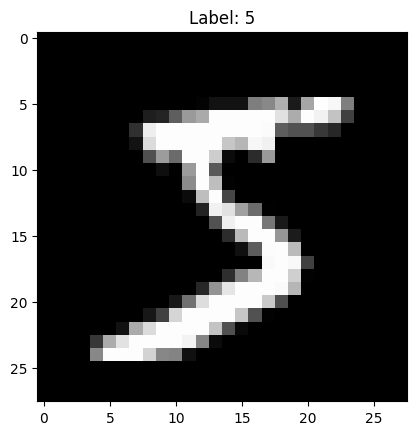

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the built-in MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Show the first image just to see what we're working with
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.show()

In [2]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape for the CNN (Adding the '1' channel for grayscale)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [3]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Step 1: Feature Extraction
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Step 2: Classification
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax') # 10 neurons for digits 0-9
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

d:\Handwritten_Digit_Recogniser\dig_rec_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Check final accuracy
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9580 - loss: 0.1367 - val_accuracy: 0.9813 - val_loss: 0.0562
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9861 - loss: 0.0450 - val_accuracy: 0.9874 - val_loss: 0.0358
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9907 - loss: 0.0311 - val_accuracy: 0.9870 - val_loss: 0.0387
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9929 - loss: 0.0226 - val_accuracy: 0.9897 - val_loss: 0.0318
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9944 - loss: 0.0170 - val_accuracy: 0.9915 - val_loss: 0.0289
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9915 - loss: 0.0289
Test Accuracy: 99.15%


In [5]:
model.save('digit_model.h5')

In [ ]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
from tensorflow.keras.models import load_model

# 1. Load the trained model
try:
    model = load_model('digit_model.h5')
except Exception as e:
    print(f"Error: {e}. Ensure 'digit_model.h5' is in the same directory.")

def process_and_predict(file_path):
    # Load image
    img = cv2.imread(file_path)
    if img is None: return None, ""
    
    # --- 1. HIGH-RES OPTIMIZATION ---
    # Downscale high-res images to a standard width (1000px) 
    # This makes processing faster and our filters consistent.
    h_orig, w_orig = img.shape[:2]
    standard_w = 1000
    scale = standard_w / w_orig
    img = cv2.resize(img, (standard_w, int(h_orig * scale)), interpolation=cv2.INTER_AREA)
    
    # --- 2. PREPROCESSING ---
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Stronger blur for high-res grain removal
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Otsu's to find the best threshold automatically
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Clean background noise and thicken the strokes
    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    thresh = cv2.dilate(thresh, kernel, iterations=1)

    # --- 3. CONTOUR DETECTION ---
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort from left to right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    output_img = img.copy()
    detected_digits = []

    for ctr in contours:
        x, y, w, h = cv2.boundingRect(ctr)
        
        # Filter based on standard_w = 1000 scale
        # If height is at least 4% of the image height, it's likely a digit
        if h > (img.shape[0] * 0.04) and w > 10:
            roi = thresh[y:y+h, x:x+w]
            
            # --- 4. ASPECT RATIO PRESERVATION (The square padding) ---
            # Instead of resizing ROI directly (which stretches digits), 
            # we place it on a square black canvas.
            pad = 20
            dim = max(w, h) + (pad * 2)
            square_canvas = np.zeros((dim, dim), dtype="uint8")
            
            # Center the ROI
            start_x = (dim - w) // 2
            start_y = (dim - h) // 2
            square_canvas[start_y:start_y+h, start_x:start_x+w] = roi
            
            # --- 5. MODEL PREDICTION ---
            final_input = cv2.resize(square_canvas, (28, 28), interpolation=cv2.INTER_AREA)
            final_input = final_input.astype("float32") / 255.0
            final_input = np.expand_dims(final_input, axis=(0, -1))
            
            preds = model.predict(final_input, verbose=0)
            digit = np.argmax(preds)
            confidence = np.max(preds)
            
            # Confidence Threshold (85% sure)
            if confidence > 0.85:
                detected_digits.append(str(digit))
                cv2.rectangle(output_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(output_img, f"{digit}", (x, y-10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    return output_img, "".join(detected_digits)

# --- 6. GUI INTERFACE ---
class OCRApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Intelligent Digit Scanner")
        self.root.geometry("800x900")
        self.root.configure(bg="#1e1e1e")

        tk.Label(root, text="AI Digit Recognition System", fg="white", bg="#1e1e1e", 
                 font=("Segoe UI", 20, "bold")).pack(pady=20)

        self.btn = tk.Button(root, text="SELECT IMAGE", command=self.load_image, 
                             bg="#0078d7", fg="white", font=("Segoe UI", 12, "bold"), 
                             padx=30, pady=12, relief="flat")
        self.btn.pack()

        self.display = tk.Label(root, bg="#2d2d2d")
        self.display.pack(pady=30)

        self.status = tk.Label(root, text="Waiting for input...", fg="#aaaaaa", 
                               bg="#1e1e1e", font=("Segoe UI", 14))
        self.status.pack(pady=10)

    def load_image(self):
        path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
        if not path: return

        self.status.config(text="Scanning...", fg="#ffcc00")
        self.root.update_idletasks()

        res_img, digit_str = process_and_predict(path)

        if res_img is not None:
            # Convert for Tkinter
            res_img = cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(res_img)
            pil_img.thumbnail((600, 600))
            tk_img = ImageTk.PhotoImage(pil_img)
            
            self.display.config(image=tk_img)
            self.display.image = tk_img
            
            if digit_str:
                self.status.config(text=f"DETECTED: {digit_str}", fg="#00ff00")
            else:
                self.status.config(text="No clear digits found.", fg="#ff4444")

if __name__ == "__main__":
    root_win = tk.Tk()
    app = OCRApp(root_win)
    root_win.mainloop()

: 